In [69]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
model_params = {
    'reaction_speed': 10, # the size of step of signal in binary model
    'max_reward': 100, # maximum reward for iteration
    'angle_loss_coeff': 1e3, #300000 # coef before punish for dismiss an angle
    'over_force_loss_coeff': 0, # coef before punish for inapropriate force (signals out of range [800, 2300])
    'upper_force_loss_coeff': 10., #3 # coef before punish for missing total force on y-axis. target_force is a target.
    'step_size': 1e-3, # time length of iteration in seconds
    # 'target_upper_force': 2.0, # total force on y-axis which wanted to be achieved and stated.
    # 'gamma': 0.99, # discount factor
    'std_angle': 0.0,
    'std_velocity': 0.0,
    'std_acceleration': 0.0,
    'std_force': 0.0,
}

In [73]:

import matplotlib.pyplot as plt
from Copter.Session import Session
from Copter.Network import Network
import torch
net = Network(6, 6)
# loaded_net.load_state_dict(torch.load('trainedNet_40_10000_50_70_rew730k.pt'))
session = Session(network=net, target_upper_force=2, **model_params)
session.step(1)

False

False


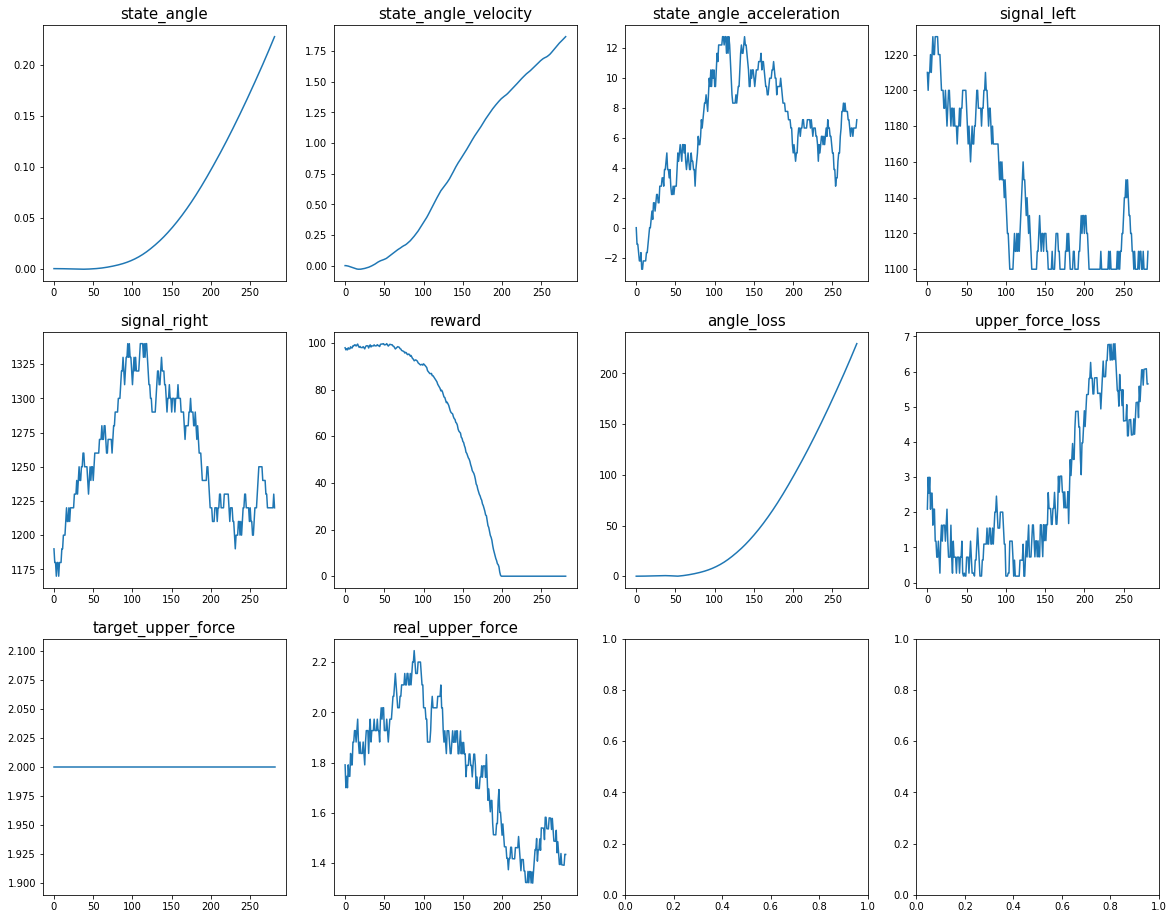

In [74]:
# net = Network(6, 4)
s = Session(network=net, target_upper_force=2, **model_params)
s.run(100000, pred_iters=100000 / 2)
print(s.success)
s.plot_logs()

DQN model

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils import to_one_hot, normalize_tensor
from typing import Tuple, Type, Dict
from Copter.Session import Session
from Copter.Network import Network
from IPython.display import clear_output
from joblib import Parallel, delayed
import time

class DQNAgent(nn.Module):
    def __init__(self, network=None, target_upper_force=None, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        # self.state_shape = state_shape
        self.network = network # gives q_vales as output

    def get_qvalues(self, states: torch.Tensor):
        """
        like forward, but works on numpy arrays, not tensors
        """
        # model_device = next(self.parameters()).device
        states = torch.tensor(states)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice([0, 1], batch_size, p=[1-self.epsilon, self.epsilon])
        return np.where(should_explore, random_actions, best_actions)

    def evaluate(self, env, agent, n_games=1, greedy=False, t_max=10000):
        """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
        rewards = []
        for _ in range(n_games):
            s = env.reset()
            reward = 0
            for _ in range(t_max):
                qvalues = agent.get_qvalues([s])
                action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
                s, r, done, _ = env.step(action)
                reward += r
                if done:
                    break

            rewards.append(reward)
        return np.mean(rewards)

CEM model

In [67]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from utils import to_one_hot, normalize_tensor
from typing import Tuple, Type, Dict
from Copter.Session import Session
from Copter.Network import Network
from IPython.display import clear_output
from joblib import Parallel, delayed
import time

class Trainer_CEM(object):
    def __init__(self, network=None, target_upper_force=None, n_iters=2000, n_sessions=50, percentile=70, use_parallel=True):
        if network is None:
            self.network = Network(6, 6)
        else:
            self.network = network
        self.session = Session(network=self.network, target_upper_force=target_upper_force, **model_params)

        # self.train_steps = train_steps
        self.n_iters = n_iters
        self.n_sessions = n_sessions
        self.percentile = percentile
        self.use_parallel = use_parallel
        self.target_upper_force = target_upper_force

        self.optimizer = torch.optim.Adam(self.network.parameters(), 1e-3)
        self.entropy_coef = 0.01 # for loss functions

        self.train_rewards = []
        self.train_elite_rewards = []
        self.train_losses = []
        self.info = []

    def generate_elites(self) -> Tuple[torch.Tensor, Tuple[torch.Tensor], Tuple[float]]:
        '''
        Generates `n_session` sessions then choose just `percentile` best of them by total reward.
        Returns 
        -state_tensor, 
        -actions_tensors, 
        -avg_rewards, 
        -info (for debug)
        which correspond to states and actions of concatenation of the best sessions.
        '''

        def generate_session():
            s = Session(self.network, target_upper_force=self.target_upper_force, **model_params)
            s.run(max_iters=self.n_iters, pred_iters=self.n_iters / 2, reset=True)
            total_reward = s.total_reward
            state_tensor = s.get_state_tensor()
            action_tensor_left, action_tensor_right = s.get_action_tensors() 
            length = s.iteration
            
            return state_tensor, action_tensor_left, action_tensor_right, total_reward, length

        start_time = time.time()
        if self.use_parallel:
            sessions = Parallel(n_jobs=-1)(delayed(generate_session)() for i in range(self.n_sessions))
            state_tensors, action_tensors_left, action_tensors_right, total_rewards, session_lenghts = zip(*sessions)
        else:
            total_rewards = []
            session_lenghts = []
            state_tensors = []
            action_tensors_left = []
            action_tensors_right = []
            session_logs = []
            for _ in range(self.n_sessions):
                self.session.run(max_iters=self.n_iters, reset=True)
                total_rewards.append(self.session.total_reward)
                state_tensors.append(self.session.get_state_tensor())
                action_tensor_left, action_tensor_right = self.session.get_action_tensors() 
                action_tensors_left.append(action_tensor_left)
                action_tensors_right.append(action_tensor_right)
                session_lenghts.append(self.session.iteration)
                session_logs.append(self.session.logs.copy())
                # print(session_tensors[-1].shape)
            self.session.reset()

        reward_threshold = np.percentile(total_rewards, self.percentile)        
        elite_states = torch.vstack([state_tensors[i] for i in range(self.n_sessions) if reward_threshold <= total_rewards[i]])
        elite_actions_left = torch.vstack([action_tensors_left[i] for i in range(self.n_sessions) if reward_threshold <= total_rewards[i]])
        elite_actions_right = torch.vstack([action_tensors_right[i] for i in range(self.n_sessions) if reward_threshold <= total_rewards[i]])

        avg_session_reward = np.mean(total_rewards)
        avg_elite_session_reward = np.mean([reward for reward in total_rewards if reward_threshold <= reward])

        info = {
            # 'total_rewards': total_rewards,
            # 'elite_rewards': [reward for reward in total_rewards if reward_threshold <= reward],
            'lenghts': session_lenghts,
            'threshold': reward_threshold,
            'timings': time.time() - start_time
            # 'log': session_logs,
        }

        return elite_states, (elite_actions_left, elite_actions_right), (avg_session_reward, avg_elite_session_reward), info
    
    def train_model_step(self):
        '''
        Makes a step of CEM algorithm
        '''
        states_tensor, actions_tensor, avg_rewards, info = self.generate_elites()
        actions_left_tensor, actions_right_tensor = actions_tensor
        avg_session_reward, avg_elite_session_reward = avg_rewards

        logits = self.network(normalize_tensor(states_tensor))
        left_log_logits = F.log_softmax(logits[:, :3], -1)
        right_log_logits = F.log_softmax(logits[:, 3:], -1)
        log_probs_for_actions = torch.sum(left_log_logits * actions_left_tensor + right_log_logits * actions_right_tensor, dim=1) 
        
        # entropy = (torch.exp(log_probs_for_actions) * log_probs_for_actions).sum()
        loss = -log_probs_for_actions.mean() #- entropy * self.entropy_coef

        # log_prob = get_log_prob(actions_tensor, preds, self.model.std)
        # loss = -(log_prob * cumulative_rewards_tensor).mean()
        self.train_losses.append(loss.item())
        self.train_rewards.append(avg_session_reward)
        self.train_elite_rewards.append(avg_elite_session_reward)
        self.info.append(info)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train_model(self, train_steps=10, print_=True):
        '''
        Trains model for several steps.
        '''
        for step in range(train_steps):
            self.train_model_step()

            if print_:
                clear_output()
                print(step)
                if step % 1 == 0:
                    self.plot_trained_logs()

    def plot_trained_logs(self):
        # r = np.convolve(self.train_rewards, np.ones(window_size), 'valid') / window_size
        # elite_r = np.convolve(self.train_elite_rewards, np.ones(window_size), 'valid') / window_size
        plt.xlabel('step')
        plt.ylabel('reward')
        # plt.title('rolling reward')
        plt.plot(self.train_elite_rewards, label='elite rewards')
        plt.plot(self.train_rewards, label='all rewards')
        plt.plot([logs['threshold'] for logs in self.info], label='threshold')
        plt.legend()
        plt.show()
        plt.title('lenghts')
        plt.plot([np.mean(logs['lenghts']) for logs in self.info], label='lengths')
        # plt.legend()
        plt.show()
        plt.title('timings')
        plt.plot([np.mean(logs['timings']) for logs in self.info], label='timings')
        plt.show()


9


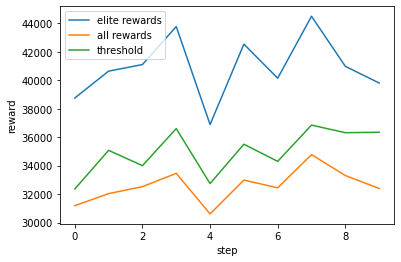

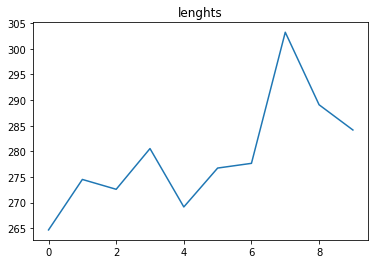

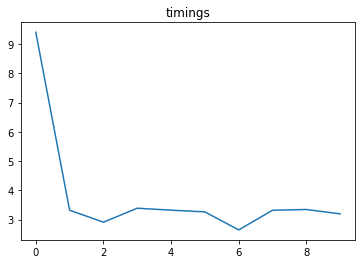

final reward:  32398.188303962135


In [68]:
tr = Trainer_CEM(network=None, n_iters=1000, n_sessions=50, percentile=70, use_parallel=True)
tr.train_model(10)
# trained_net = tr.network
# tr.plot_trained_logs()
print('final reward: ', tr.train_rewards[-1])

In [5]:
# torch.save(tr.network.state_dict(), 'trainedNet_40_10000_50_70_rew730k.pt')

loaded_net = Network(6, 4)
loaded_net.load_state_dict(torch.load('trainedNet_40_10000_50_70_rew730k.pt'))

<All keys matched successfully>

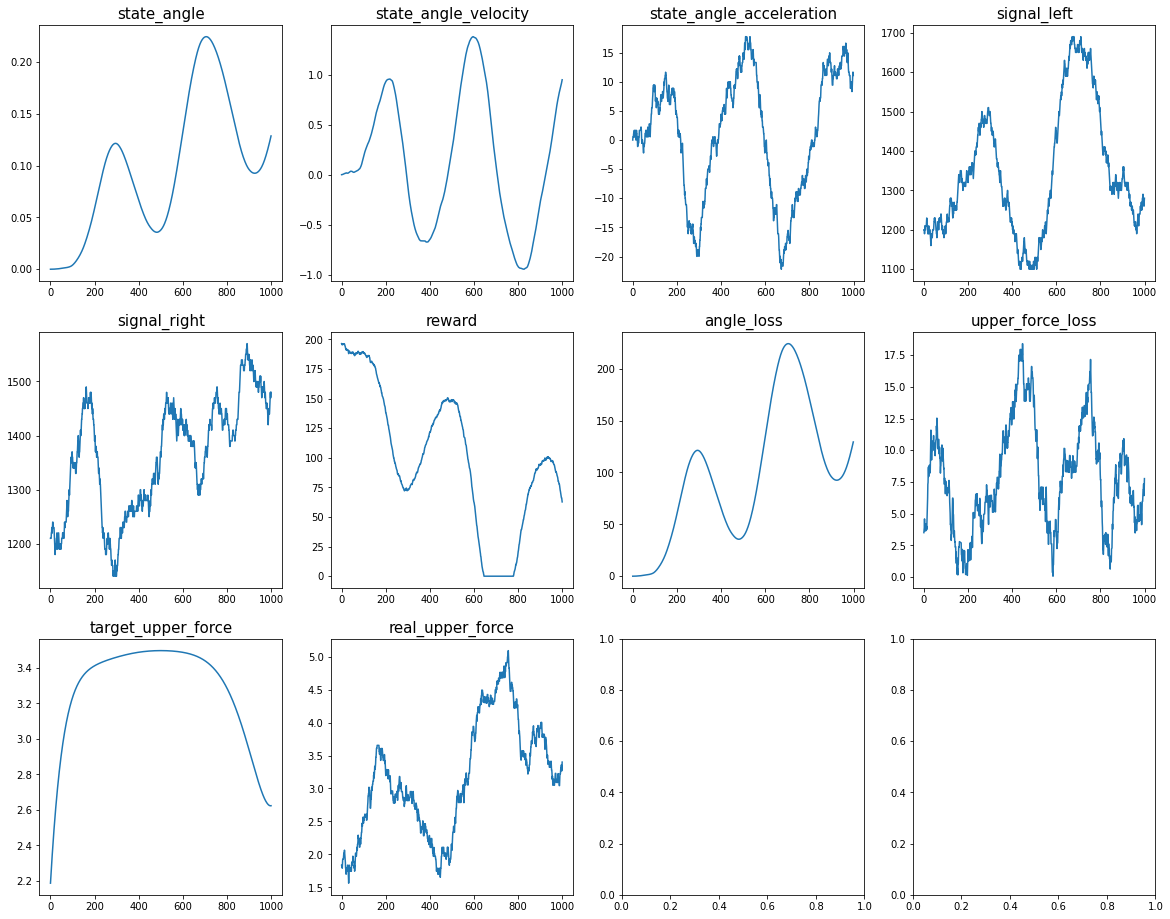

In [54]:
tr.session.run(1000, pred_iters=1000)
tr.session.plot_logs()

Force dynamic function

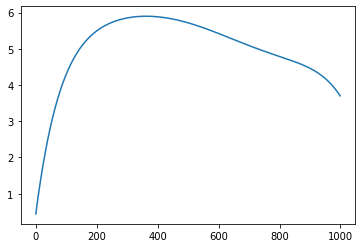

In [9]:
from utils import signal_to_force
from model_parameters import MIN_SIGNAL, MAX_SIGNAL

k = 10
n_ticks = 1000
coefs = np.random.randint(-5, 5, k)
step_interval = 2 / n_ticks
def polynom(x):
    x_deg = 1
    ans = 0
    for c in coefs:
        ans += c * x_deg
        x_deg *= x
    return ans

arr = [polynom(x) for x in np.arange(-1, 1, step_interval)]
min_force, max_force = signal_to_force(MIN_SIGNAL), signal_to_force(MAX_SIGNAL)
coef = (max_force - min_force) / (max(arr) - min(arr))
min_a = min(arr)
forces = [min_force + coef * (a - min_a) for a in arr]
plt.plot(forces)

